# FVI Clustering

This notebook filters frames based on FVI scores, creates embeddings for the selected frames, and clusters the embeddings.

In [2]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import random


# Add the path to the scripts directory
import sys
sys.path.append('../scripts')
print(np.__version__)

1.26.4


## Load FVI Scores

Load the FVI scores from the `fvi_scores.json` file.

In [3]:
def load_fvi_scores(directory):
    fvi_scores = {}
    for root, _, files in os.walk(directory):
        for file in files:
            if file == 'fvi_scores.json':
                filepath = os.path.join(root, file)
                with open(filepath, 'r') as f:
                    scores = json.load(f)
                    fvi_scores[root] = scores
    return fvi_scores

fvi_scores = load_fvi_scores('../output/ground_truth')
fvi_scores

{'../output/ground_truth\\408\\VID002A\\preds': [99.45853407325085,
  90.56489386070079,
  88.99438184514796,
  93.50935782048768,
  87.88060081724521,
  114.32847414358332,
  107.19141756689292,
  93.47726996441435,
  98.86859966642594,
  98.49365461794989,
  100.9554357129917,
  99.06058752097123,
  97.72410142846032,
  96.36908217888141,
  74.47147104764348,
  65.77993615077473,
  80.85790004693419,
  90.22194854911969,
  75.88807547961669,
  72.46378405796926,
  68.1395626636978,
  47.52893855326458,
  69.34695379034324,
  73.23933369440222,
  72.47758274114831,
  88.67355862939075,
  87.92610533851708,
  69.35416353759881,
  70.50531894828929,
  66.57326790837296,
  91.09884741312592,
  68.28616258071617,
  69.62758074211685,
  69.10137480542626,
  72.49137879775773,
  84.19026071939675,
  80.93207028119323,
  81.58431221748455,
  69.03622237637282,
  81.69455306200041,
  67.23838189605696,
  75.8023746329889,
  73.90534486760751,
  84.03570669661795,
  77.68526243760782,
  79.642

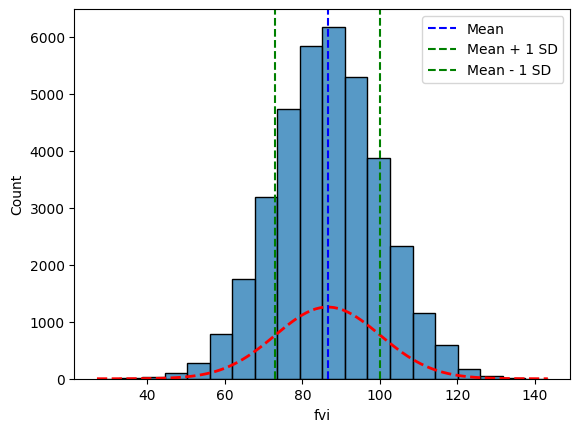

In [4]:
# create a chart to show the distribution of the fvi scores
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import norm

# Example fvi_scores dictionary for demonstration purposes
fvi_scores_list = []
for root, scores in fvi_scores.items():
    for score in scores:
        fvi_scores_list.append(score)

df = pd.DataFrame(fvi_scores_list, columns=['fvi'])

sns.histplot(df, x='fvi', bins=20)

# add a bell curve
mu, std = norm.fit(df['fvi'])
min_fvi, max_fvi = df['fvi'].min(), df['fvi'].max()
x = np.linspace(min_fvi, max_fvi, 100)
y = norm.pdf(x, mu, std) * len(df) * (x[1] - x[0])
plt.plot(x, y, 'r--', linewidth=2)

# Add standard deviation lines
plt.axvline(mu, color='blue', linestyle='--', label='Mean')
plt.axvline(mu + std, color='green', linestyle='--', label='Mean + 1 SD')
plt.axvline(mu - std, color='green', linestyle='--', label='Mean - 1 SD')
plt.legend()

plt.show()

## Filter Frames

Filter frames with FVI scores above a certain threshold.
low FVI scores => redundant

In [5]:
threshold = 60 # 
selected_frames_images = []
selected_frames = []
for directory, scores in fvi_scores.items():
    for i, score in enumerate(scores):
        if score > threshold:
            # Adjusting the directory path to replace "../output/ground_truth" with "/data"
            adjusted_directory = directory.replace("../output", "../data")
            adjusted_directory = adjusted_directory.replace("\\", "/")
            adjusted_directory_image = directory.replace("../output/ground_truth", "../output/video_frames")

            # Adjusting the directory path to replace "/preds" with ""
            adjusted_directory_image = adjusted_directory_image.replace("preds", "")

            frame_path = os.path.join(adjusted_directory, f'{i+1:04d}.json')
            image_path = os.path.join(adjusted_directory_image, f'{i+1:04d}.jpg')
            image_path = image_path.replace("\\", "/")
            frame_path = frame_path.replace("\\", "/")
            selected_frames_images.append(image_path)
            selected_frames.append(frame_path)

print(len(selected_frames))
print(selected_frames[:5])
print(selected_frames_images[:5])

36362
['../data/ground_truth/408/VID002A/preds/0001.json', '../data/ground_truth/408/VID002A/preds/0002.json', '../data/ground_truth/408/VID002A/preds/0003.json', '../data/ground_truth/408/VID002A/preds/0004.json', '../data/ground_truth/408/VID002A/preds/0005.json']
['../output/video_frames/408/VID002A/0001.jpg', '../output/video_frames/408/VID002A/0002.jpg', '../output/video_frames/408/VID002A/0003.jpg', '../output/video_frames/408/VID002A/0004.jpg', '../output/video_frames/408/VID002A/0005.jpg']


In [6]:
sys.path.append('../scripts')

from coco_converter import convert_selected_frames_to_coco

convert_selected_frames_to_coco(selected_frames, '../output/selected_frames_coco.json')

KeyboardInterrupt: 

## Create Embeddings

Use a pre-trained ResNet model from PyTorch to create embeddings for the selected frames.

In [ ]:
import torch
print(torch.cuda.is_available()) # run nvidia-smi to check if GPU is available

True


In [7]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import fiftyone as fo
import fiftyone.brain as fob
from sklearn.cluster import KMeans

sys.path.append('../scripts')

from embeddings_generator import process_image, generate_embeddings
from coco_converter import convert_selected_images_to_coco
image_paths = selected_frames_images
# Generate embeddings for all images
embeddings = generate_embeddings(image_paths)

# inertia 
# Perform KMeans Clustering on Embeddings
valid_embeddings = [embedding for embedding in embeddings if embedding is not None]  # Filter out None values
n_clusters = 50  # of clusters  from 2 to 15. n_ too high if only we have 1 point in cluster.
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto")
cluster_labels = kmeans.fit_predict(valid_embeddings)
clusters = kmeans.labels_
cluster_dict = []
for idx, cluster in enumerate(cluster_labels):
    # cluster_dict[cluster]['embedding'].append(valid_embeddings[idx])
    cluster_dict.append({"cluster": cluster, "embedding": valid_embeddings[idx], "file_path": image_paths[idx]})

# print(cluster_dict[:2])

# print("Print Centroids")
representatives = []
centroids = kmeans.cluster_centers_
m = 2 # 2~3
# 2 => 2 ~ 15 clusters
# 3 => 2 ~ 10 clusters
# 4 => 

# find the optimal number of clusters

# The sampled points that we want
closest_points = {}

for cluster_id, centroid in enumerate(centroids):
    distances = np.linalg.norm(embeddings - centroid, axis=1)
    closest_indices = np.argsort(distances)[:m]
    closest_points[cluster_id] = closest_indices
    

# Find the closest images to each centroid
representatives = []  # List to store representative images for each cluster

# Iterate over each cluster and find the closest points
for cluster_id, centroid in enumerate(centroids):
    # Compute distances from all valid embeddings to the centroid
    distances = np.linalg.norm(np.array(valid_embeddings) - centroid, axis=1)
    
    # Get indices of the closest images (m closest points)
    closest_indices = np.argsort(distances)[:m]
    
    # Create a dictionary for this cluster with image paths and embeddings
    cluster_representative = {
        "cluster": cluster_id,
        # "centroid": centroid.tolist(),  # Convert centroid to list for better readability
        "closest_images": [
            {
                "file_path": image_paths[idx],
                # "embedding": valid_embeddings[idx].tolist()  # Convert embedding to list
            }
            for idx in closest_indices
        ]
    }
    
    representatives.append(cluster_representative)

# Print representatives for all clusters
print(representatives)

# print representations from cluster 0
for rep in representatives:
    if rep['cluster'] == 0:
        print(rep)



selected_representatives_images = []
for rep in representatives:
    for path in rep["closest_images"]:
        selected_representatives_images.append(path['file_path'])

print(len(selected_representatives_images))

# Convert list to a dictionary with keys and values being the same
my_dict = {item: item for item in selected_representatives_images}

# Write the dictionary to a JSON file
with open('../output/selected_representatives_image.json', 'w') as json_file:
    json.dump(my_dict, json_file)

# => 

convert_selected_images_to_coco(selected_representatives_images, '../output/selected_representatives_coco.json')


# for sample, label in zip(dataset, cluster_labels): 
#     print(label)
#     sample["cluster"] = label
#     sample.save()
    

# Use the Array Number => Find the Matching Images => Generate COCO file => Visualize

c:\Users\yoopo\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yoopo\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[{'cluster': 0, 'closest_images': [{'file_path': '../output/video_frames/PB/VID001A/0910.jpg'}, {'file_path': '../output/video_frames/PB/VID001A/0906.jpg'}]}, {'cluster': 1, 'closest_images': [{'file_path': '../output/video_frames/408/VID002B/4898.jpg'}, {'file_path': '../output/video_frames/408/VID002B/4902.jpg'}]}, {'cluster': 2, 'closest_images': [{'file_path': '../output/video_frames/PB/VID001B/2110.jpg'}, {'file_path': '../output/video_frames/PB/VID001B/2675.jpg'}]}, {'cluster': 3, 'closest_images': [{'file_path': '../output/video_frames/PB/VID001A/2114.jpg'}, {'file_path': '../output/video_frames/PB/VID001A/2686.jpg'}]}, {'cluster': 4, 'closest_images': [{'file_path': '../output/video_frames/408/VID002B/2378.jpg'}, {'file_path': '../output/video_frames/408/VID002B/2355.jpg'}]}, {'cluster': 5, 'closest_images': [{'file_path': '../output/video_frames/PB/VID001B/1348.jpg'}, {'file_path': '../output/video_frames/PB/VID001B/1220.jpg'}]}, {'cluster': 6, 'closest_images': [{'file_path':

In [8]:
import fiftyone as fo
import fiftyone.brain as fob


# dataset_rest = fo.Dataset.from_images(selected_frames_images)
dataset = fo.Dataset.from_dir(
    data_path="../output/selected_representatives_image.json",
    labels_path="../output/selected_representatives_coco.json",
    dataset_type=fo.types.COCODetectionDataset,
)

# for filepath, embedding in zip(image_paths, embeddings):
#     if embedding is not None:  # Ensure valid embedding exists
#         sample = fo.Sample(filepath=filepath)
#         sample["embedding"] = embedding.tolist()  # Convert NumPy array to list for storage in FiftyOne
#         dataset.add_sample(sample)

fob.compute_visualization(
    dataset,
    embeddings="resnet101",
    method="tsne",
    brain_key="tsne_resnet101_test",
    patches_field="detections"
)

 100% |███████████████████| 20/20 [1.3s elapsed, 0s remaining, 15.6 samples/s]         
Computing patch embeddings...
 100% |███████████████████| 20/20 [7.1s elapsed, 0s remaining, 2.8 samples/s]      
Generating visualization...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 193 samples in 0.001s...
[t-SNE] Computed neighbors for 193 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 193 / 193
[t-SNE] Mean sigma: 2.133128
[t-SNE] Computed conditional probabilities in 0.003s
[t-SNE] Iteration 50: error = 60.5534439, gradient norm = 0.3619184 (50 iterations in 0.019s)
[t-SNE] Iteration 100: error = 58.8619232, gradient norm = 0.3151302 (50 iterations in 0.014s)
[t-SNE] Iteration 150: error = 59.1574860, gradient norm = 0.3011167 (50 iterations in 0.018s)
[t-SNE] Iteration 200: error = 61.5864868, gradient norm = 0.2928632 (50 iterations in 0.016s)
[t-SNE] Iteration 250: error = 61.7677841, gradient norm = 0.2789551 (50 iterations in 0.015s)
[t-SNE] KL 

c:\Users\yoopo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Iteration 600: error = 0.3466982, gradient norm = 0.0008071 (50 iterations in 0.016s)
[t-SNE] Iteration 650: error = 0.3433633, gradient norm = 0.0005833 (50 iterations in 0.024s)
[t-SNE] Iteration 700: error = 0.3430272, gradient norm = 0.0007153 (50 iterations in 0.016s)
[t-SNE] Iteration 750: error = 0.3376707, gradient norm = 0.0004746 (50 iterations in 0.019s)
[t-SNE] Iteration 800: error = 0.3380265, gradient norm = 0.0002305 (50 iterations in 0.016s)
[t-SNE] Iteration 850: error = 0.3380206, gradient norm = 0.0001944 (50 iterations in 0.015s)
[t-SNE] Iteration 900: error = 0.3377930, gradient norm = 0.0002114 (50 iterations in 0.015s)
[t-SNE] Iteration 950: error = 0.3374667, gradient norm = 0.0002039 (50 iterations in 0.018s)
[t-SNE] Iteration 1000: error = 0.3372639, gradient norm = 0.0002972 (50 iterations in 0.021s)
[t-SNE] KL divergence after 1000 iterations: 0.337264


In [9]:
print(dataset)

Name:        2024.12.14.15.39.22
Media type:  image
Num samples: 20
Persistent:  False
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    detections:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    segmentations:    fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


In [10]:
session = fo.launch_app(dataset)
session.wait()

Notebook sessions cannot wait


# SAMPLING BY CLUSTERS

# k-MEANS SET THE NUMBER OF CLUSTERS BY WHAT WE WANT, Allow it with to chajnge k-means value ;find points closest to cetroid

number of points closest to coentroid

i
# ITERATE CLUSTERS AND CHOOSE FRAMES THAT ARE CLOSEST TO THE CETREOID;u,i